Mean MSE: Leave one out 1.0473, 10 folds 1.1142, 5 folds 1.0906, Test MSE: 1.0810
Mean MSE: Leave one out 0.9550, 10 folds 0.9845, 5 folds 0.9581, Test MSE: 0.9713
Mean MSE: Leave one out 0.8994, 10 folds 0.9652, 5 folds 0.9160, Test MSE: 1.0866
Mean MSE: Leave one out 0.8982, 10 folds 0.9197, 5 folds 0.8752, Test MSE: 1.3369
Mean MSE: Leave one out 0.9244, 10 folds 0.9374, 5 folds 0.9152, Test MSE: 1.2067


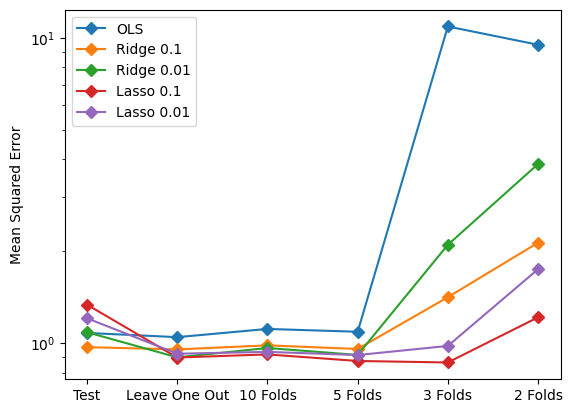

In [59]:
from numpy.random import seed, uniform, normal
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

seed(0)

def Runge(x):
    return 1 / (1 + 25 * x**2)

VARIANCE = 1
N_POINTS = 50

x = uniform(-3, 3, N_POINTS)
y = Runge(x) + normal(0, VARIANCE, N_POINTS)
pol = PolynomialFeatures(degree=10)


def cross_validation(k_folds, optimization_method):
    mean_mse = 0.
    for k in range(k_folds):
        train_idx = [i for i in range(N_POINTS) if i%k_folds!=k]
        test_idx = [i for i in range(N_POINTS) if i%k_folds==k]
        
        x_train = x[train_idx]
        y_train = y[train_idx]

        x_test = x[test_idx]
        y_test = y[test_idx]

        X = pol.fit_transform(x_train.reshape(-1, 1))

        scalar = StandardScaler()
        X = scalar.fit_transform(X)
        y_mean = y_train.mean()
        y_train -= y_mean
        y_train -= y_mean

        reg = optimization_method.fit(X, y_train)

        y_pred = reg.predict(scalar.transform(pol.transform(x_test.reshape(-1, 1))))

        mse = mean_squared_error(y_test, y_pred)

        mean_mse += mse / k_folds

    return mean_mse

test_data = uniform(-3, 3, N_POINTS)
for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:

    mean_mse_LEAVE_ONE_OUT = cross_validation(N_POINTS, optimization_method)
    mean_mse_10_FOLDS = cross_validation(10, optimization_method)
    mean_mse_5_FOLDS = cross_validation(5, optimization_method)
    mean_mse_3_FOLDS = cross_validation(3, optimization_method)
    mean_mse_2_FOLDS = cross_validation(2, optimization_method)

    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()
    y_true = Runge(test_data) + normal(0, VARIANCE, N_POINTS)

    print(f"Mean MSE: Leave one out {mean_mse_LEAVE_ONE_OUT:.4f}, 10 folds {mean_mse_10_FOLDS:.4f}, 5 folds {mean_mse_5_FOLDS:.4f}, Test MSE: {mean_squared_error(y_true, y_pred):.4f}")
    plt.plot(range(6), [mean_squared_error(y_true, y_pred), mean_mse_LEAVE_ONE_OUT, mean_mse_10_FOLDS, mean_mse_5_FOLDS, mean_mse_3_FOLDS, mean_mse_2_FOLDS], 'D-', label=name)

plt.xticks(range(6), ['Test', 'Leave One Out', '10 Folds', '5 Folds', '3 Folds', '2 Folds'])
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')
plt.show()

We used n=50 datapoints uniformly distributed on the interval (-3, 3) to test how well cross validation predicts the accuracy of our model for OLS, Ridge and Lasso both with lambda = 0.1, 0.01. For the number of k-folds we used k = 5, 10, n and compared the prediction to another 50 points, uniformly distributed on (-3, 3). The results show that for k = 2, 3 we get estimated MSE that are not in the same magnitude as the MSE of the test data. For k = 5, 10, n we get MSE roughly like the MSE of the test data. This resembles what would be expected, as the portion of left out data of the training sinks significantly as we increase k. This trend shows for all tested optimization algorithms but was especially strong for OLS and Ridge. The exact results are in Table XXX.